In [120]:

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import data_download
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model
import statsmodels.stats as stats
import statsmodels.stats.api as sms
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import RFE

%matplotlib inline
pd.set_option('display.max_columns', None)

## Load data
1. All 3 tables are merged
2. Tables are filtere to only include sales in 2019 of homes between 120,000 and 3,000,000 dollars
3. Merged table is divided into 2 tables: ordtable = ordinal features, cattable = categorical features.

We chose to separate the tables to make modeling easier, and make clear what needs to be one-hotted before adding to the model.

In [121]:
ordtable, cattable = data_download.get_tables(data_download.get_dataframes())

Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
    
Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip
    


C:\Users\caell\new_Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
    


C:\Users\caell\new_Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Successfully downloaded ZIP file
    https://aqua.kingcounty.gov/extranet/assessor/Lookup.zip
    


## Correlation matrix heatmap of ordinal features

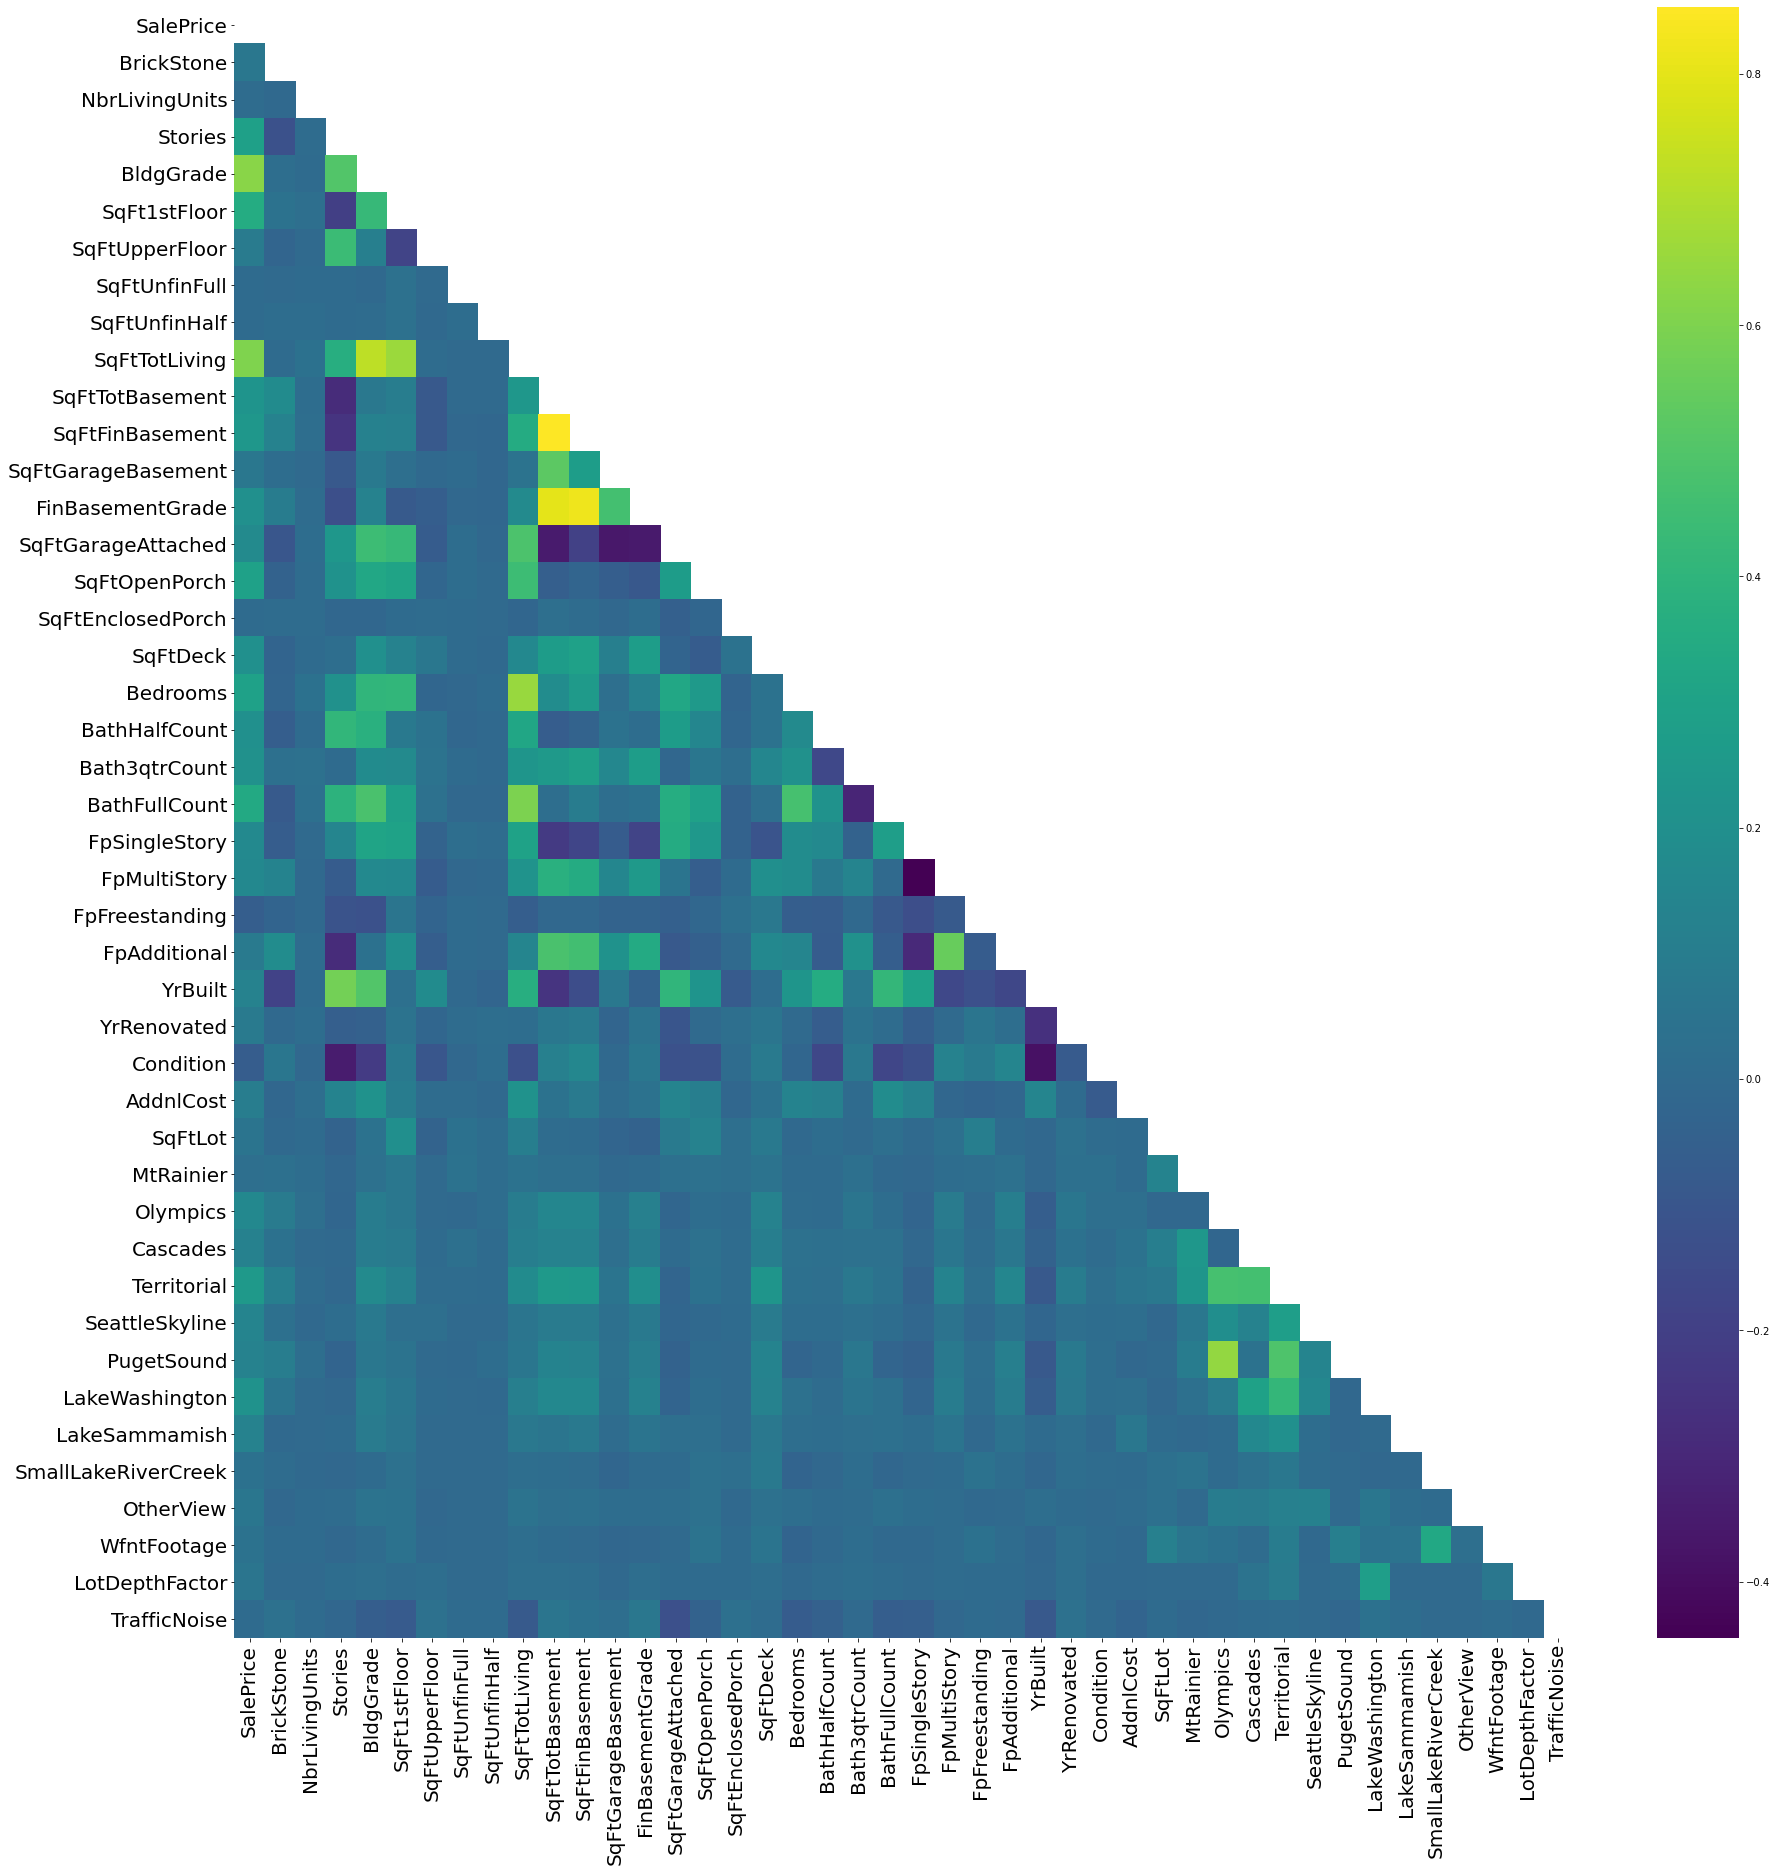

In [161]:
mask = np.triu(np.ones_like(ordtable.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (30,30))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(ordtable.corr(), mask= mask, ax = ax, cmap = 'viridis')

The above heatmap shows that just under half of the ordinal features have low correlation to the other features, while over half have higher correlation to one or more other features.

## Correlation matrix heatmap of 20 features most highly correlated to `SalePrice`

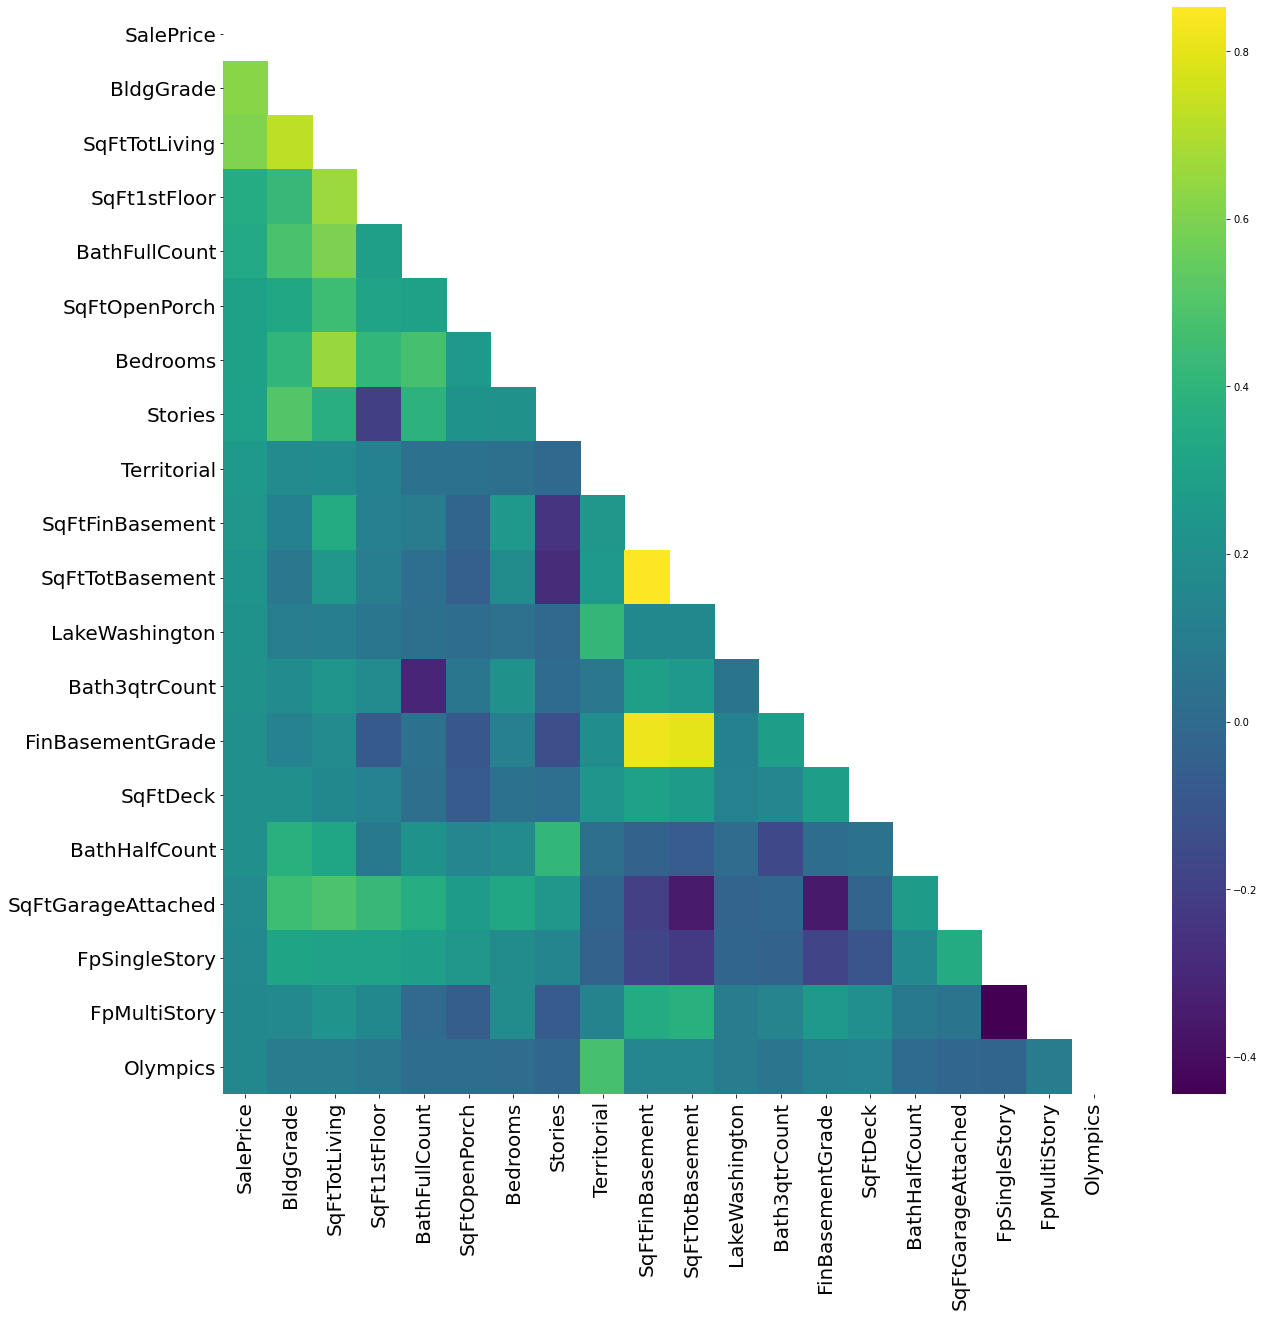

In [152]:
ordcorrs = ordtable.corr()['SalePrice'].abs().sort_values(ascending = False).head(20)
bigcorrs = ordtable[list(ordcorrs.index)]

mask = np.triu(np.ones_like(bigcorrs.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (20,20))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(bigcorrs.corr(), mask= mask, ax = ax, cmap = 'viridis')

We worked with the above high correlation features, adding and removing features and checking correlation again, but I was not able to get a higher R<sup>2</sup> than the recursive feature elimination algorithm, nor a lower condition score.  I chose to let the RFE do the work for me, and let it choose from the entire ordinal set of features.

## Standardize and scale the features to better interpret coefficients

In [236]:
pt = preprocessing.StandardScaler()
SalePrice = ordtable['SalePrice']
standardords = pd.DataFrame(pt.fit_transform(ordtable))
standardords.columns = ordtable.columns


## Let RFE choose my features for me

After a lot of experimentation, I chose 17 features.  More than that increase my condition score to unacceptable levels, and less than that reduced the R<sup>2</sup> score.

In [237]:
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=17)
select = select.fit(X = standardords.drop('SalePrice', axis=1), y = standardords['SalePrice'])
predictors = standardords[standardords.columns[[True] + list(select.support_) ]]

#### Let's see what the correlation matrix looks like for the features that the RFE chose.

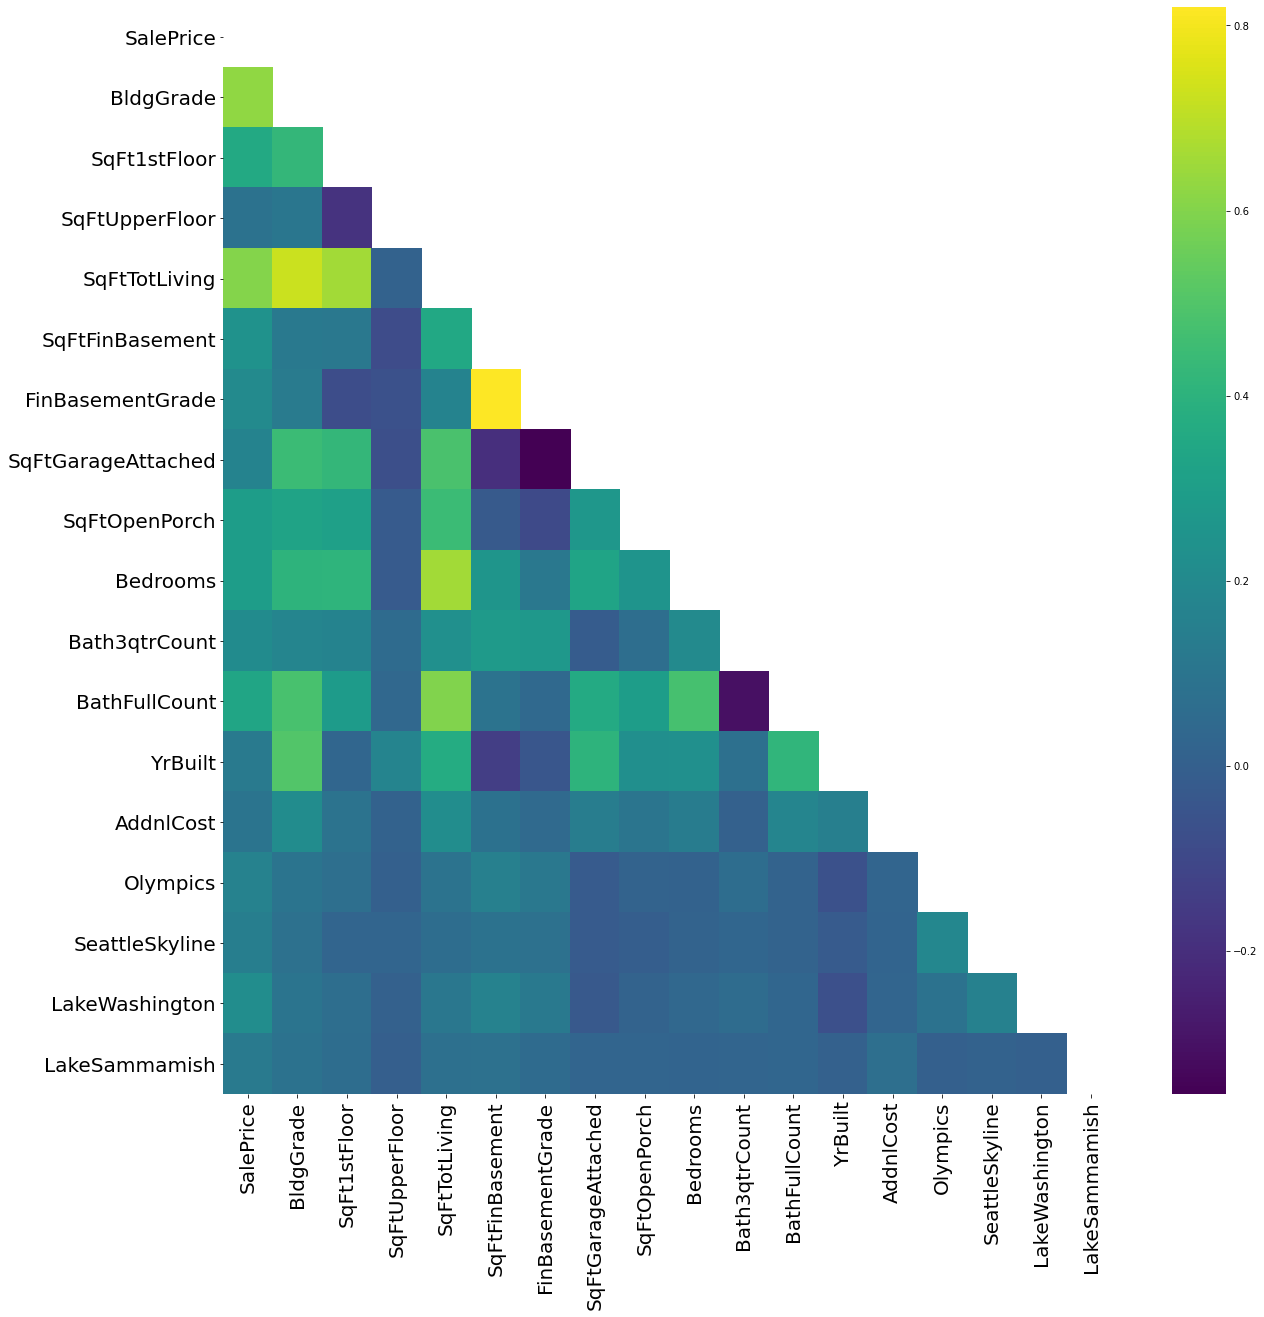

In [169]:
mask = np.triu(np.ones_like(predictors.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize = (20,20))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.heatmap(predictors.corr(), mask= mask, ax = ax, cmap = 'viridis')

We still see some collinearity, but less than the set of features I chose using correlation to `SalePrice` above.  We see that `FinBasementGrade` has high correlation with a few other features, but low correlation with `SalesPrice`.  Let's drop that one.  In fact, compared to previous tests, this slightly improves our R<sup>2</sup> score, while reducing the condition score.  It's a small difference, but a good one.

In [170]:
predictors = predictors.drop(columns = ['FinBasementGrade'])

## Feed the selected predictors into the regression model

In [172]:
preds = 'SalePrice ~ ' + str(predictors.columns[1])
for pred in predictors.columns[2:]:
    preds = preds + f' + {pred}'
formula = preds

model = smf.ols(formula = formula, data = predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     2094.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:36:49   Log-Likelihood:                -28609.
No. Observations:               27924   AIC:                         5.725e+04
Df Residuals:                   27907   BIC:                         5.739e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.082e-17      0.004   5.16e-15      1.000      -0.008       0.008
BldgGrade              0.4784      0.007     73.360      0.000       0.466       0.491
SqFt1stFloor          -0.0991      0.006    -16.043      0.000      -0.111      -0.087
SqFtUpperFloor         0.0348      0.004      8.080      0.000       0.026       0.043
SqFtTotLiving          0.4564      0.011     43.205      0.000       0.436       0.477
SqFtFinBasement       -0.0569      0.005    -10.548      0.000      -0.067      -0.046
SqFtGarageAttached    -0.1237      0.005    -22.875      0.000      -0.134      -0.113
SqFtOpenPorch          0.0529      0.005     11.392      0.000       0.044       0.062
Bedrooms              -0.1206      0.006    -21.523      0.000      -0.132      -0.110
Bath3qtrCount          0.1030      0.005     18.950      0.000       0.092       0.114
BathFullCount          0.0931      0.007     13.860      0.000       0.080       0.106
YrBuilt               -0.2561      0.006    -46.233      0.000      -0.267      -0.245
AddnlCost             -0.0475      0.004    -11.390      0.000      -0.056      -0.039
Olympics               0.0452      0.004     10.793      0.000       0.037       0.053
SeattleSkyline         0.0487      0.004     11.677      0.000       0.040       0.057
LakeWashington         0.0974      0.004     23.372      0.000       0.089       0.106
LakeSammamish          0.0614      0.004     15.075      0.000       0.053       0.069
==============================================================================
Omnibus:                     8142.350   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49373.357
Skew:                           1.265   Prob(JB):                         0.00
Kurtosis:                       9.003   Cond. No.                         6.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation
0. Caveat: Our model only accounts for less than 55% of the variances in pricing of single family homes in 2019.  This interpretation should be taken with a grain of salt.
<br/><br/>
1. Square Feet of Living Space: We see that the total square foot of living space, living space is highly positively correlated to sale price.  Only building grade has a higher correlation.  This strongly suggests that increasing house size will increase the value of a house.
<br/><br/>
2. Building Grade: While much of building grade is set at the construction of the house, homeowners can improve this by remodeling with higher quality materials, fixtures, and architectural design.  This may have the strongest effect on resale value.
<br/><br/>
3. Open Porches: Our model chose open porches as a feature that correlates positively to sale price.  This means that building an open porch is likely to increase the sale value of a home.
<br/><br/>
4. Full and 3/4 Bathrooms:  While not as influential as living space and building grade, more full bathrooms are correlated to a higher value home.  Adding a bathroom is likely to increase sale price.
<br/><br/>
5. Bedrooms: While this coefficient is negative, remember that a change in this feature assumes that the size of the living space does not change.  This would be equivalent to turning a living room into a bedroom or something similar.  When compared to the value of increasing the living space, we see that adding a bedroom to the exterior, there by increasing the total square footage, would still be a net positive value increase.  However, it should be noted, that the benefit would usually be less than adding a bathroom, depending on how much total living space the rennovation added.

#### Appendix
BUILDING GRADE
    	Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

## Let's check an assumption or two

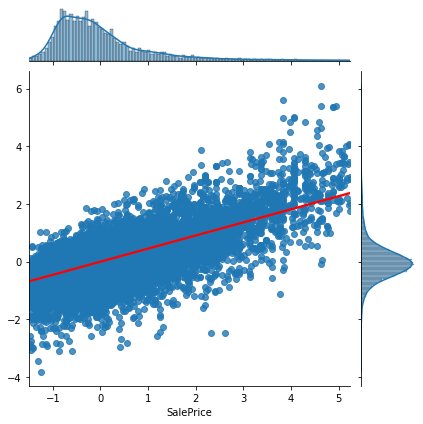

In [173]:
sns.jointplot(x = predictors['SalePrice'], y = model.resid, kind = 'reg', line_kws = {'color':"red"})

### The errors look normal and condition number is low (low multicollinearity)


#### But: 
1. We see heteroskedastic. 
2. Our errors are correlated to our target.

# Next steps: 

1. Examine linearity
2. Try to reduce heteroskedasticity
3. See what we can do about the correlation of errors to target
4. Try log scaling, or cube scaling on target variables to reduce it's skew.
5. One-hot `BldgGrade`
6. Add other categorical features to improve R<sup>2</sup>

